In [8]:
%matplotlib inline
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

data_dir = pathlib.Path("data/mini_speech_commands")
if not data_dir.exists():
    print("Downloading data.")
    tf.keras.utils.get_file(
        'mini_speech_commands.zip',
        origin='http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip',
        extract=True,
        cache_dir='.', cache_subdir='data')

something something plot the audio file we choose to work with.
[paper describing the full dataset](https://arxiv.org/pdf/1804.03209.pdf)

waveform length:  16000


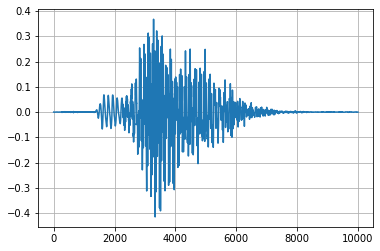

In [12]:
file = b'data/mini_speech_commands/go/ffd2ba2f_nohash_3.wav'
num_samples = 1

parts = tf.strings.split(file, os.path.sep)
label = parts[-2]
audio_binary = tf.io.read_file(file)
audio, _ = tf.audio.decode_wav(audio_binary)
audio = tf.squeeze(audio, axis=1)

zero_padding = tf.zeros([16000] - tf.shape(audio), dtype=tf.float32)
waveform = tf.cast(audio, tf.float32)
padded_waveform = tf.concat([waveform, zero_padding], 0)

fig, ax = plt.subplots()
print("waveform length: ", waveform.shape[0])
time_scale = np.arange(0, 10000)

# let's not display the full waveform as the end is just trailing silence
ax.plot(time_scale, waveform.numpy()[0:10000])
ax.grid()

Let's see what the different windowing functions look like.

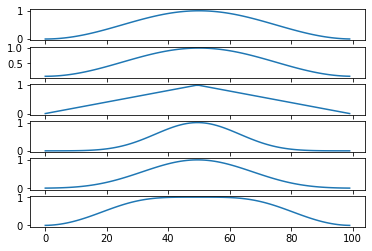

In [112]:
xscale = np.arange(0, 100) # arbitrary x scale
hann = tf.signal.hann_window(100)
hamming = tf.signal.hamming_window(100)
bartlett = np.bartlett(100)
vorbis = tf.signal.vorbis_window(100)
kaiserB8p6 = tf.signal.kaiser_window(100, beta=8.6) # similar to Blackman window
kaiserB14 = tf.signal.kaiser_window(100, beta=14)

_, axs = plt.subplots(6)
axs[0].plot(xscale, hann)
axs[1].plot(xscale, hamming)
axs[2].plot(xscale, bartlett)
axs[3].plot(xscale, kaiserB14)
axs[4].plot(xscale, kaiserB8p6)
axs[5].plot(xscale, vorbis)

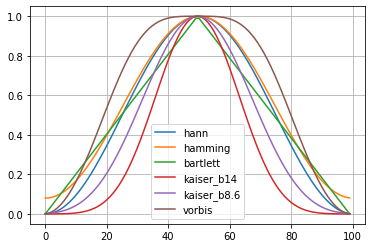

In [113]:
_, ax = plt.subplots()
ax.plot(xscale, hann, label='hann')
ax.plot(xscale, hamming, label='hamming')
ax.plot(xscale, bartlett, label='bartlett')
ax.plot(xscale, kaiserB14, label='kaiser_b14')
ax.plot(xscale, kaiserB8p6, label='kaiser_b8.6')
ax.plot(xscale, vorbis, label='vorbis')
ax.legend()
ax.grid()

By default, tensorflow will use the hamming window, but we see that we can have discontinuities at the window boundaries due to the windowing function not being 0. [Other windowing functions](https://en.wikipedia.org/wiki/Window_function)

The frequency is 7 Hz


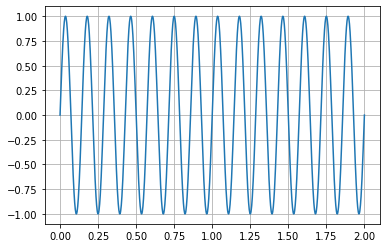

In [138]:
xscale = np.linspace(0, 2, 1000) # arbitrary x scale
print("The frequency is 7 Hz")
sin = np.sin(7*2*np.pi*xscale)
plt.plot(xscale, sin)
plt.grid()

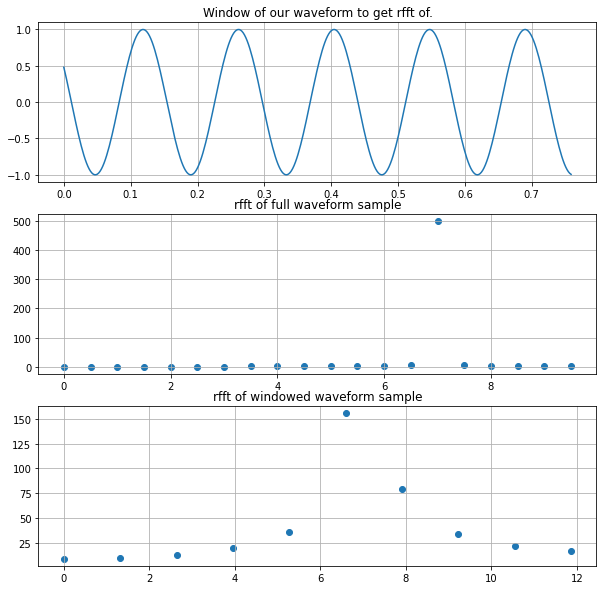

In [148]:
# we note that this snippet isn't perfectly periodic
figs, axs = plt.subplots(3, figsize=(10, 10))
win_end = 410
win_start = 30
win_len = win_end - win_start
windowed_sin = sin[win_start:win_end]
windowed_xscale = xscale[0:win_len]

axs[0].plot(windowed_xscale, windowed_sin)
axs[0].grid()
axs[0].title.set_text("Window of our waveform to get rfft of.")

# we note here that our input function is perfectly periodic so we have a clean transform
rfft = tf.signal.rfft(sin)
samples_h = np.arange(0, rfft.shape[0])/xscale[-1]
axs[1].scatter(samples_h[0:20], tf.abs(rfft[0:20]))
axs[1].grid()
axs[1].title.set_text("rfft of full waveform sample")

rfft = tf.signal.rfft(windowed_sin)
samples_h = np.arange(0, rfft.shape[0])/windowed_xscale[-1]
axs[2].scatter(samples_h[0:10], tf.abs(rfft[0:10]))
axs[2].grid()
axs[2].title.set_text("rfft of windowed waveform sample")

Right so what I think is happening is that the tensorflow rfft is assuming that our input is in the range \[0,1\] and so we need to scale the resulting transform depending on what range we actually give it. This gets our central peak in both transforms to be around the correct mark.

In [153]:
windowed_sin_hann = windowed_sin * tf.signal.hann_window(win_len)
windowed_sin_hamming = windowed_sin * tf.signal.hamming_window(win_len)
windowed_sin_vorbis = windowed_sin * tf.signal.vorbis_window(win_len)
windowed_sin_kaiserB8p6 = windowed_sin * tf.signal.kaiser_window(win_len, beta=8.6)
windowed_sin_kaiserB14 = windowed_sin * tf.signal.kaiser_window(win_len, beta=14)

def do_rfft(window):
    rfft = tf.signal.rfft(window)
    samples_h = np.arange(0, rfft.shape[0])/windowed_xscale[-1]
    return samples_h[0:20], tf.abs(rfft[0:20])

s1, f1 = do_rfft(windowed_sin_hann)
s2, f2 = do_rfft(windowed_sin_hamming)
s3, f3 = do_rfft(windowed_sin_vorbis)
s4, f4 = do_rfft(windowed_sin_kaiserB8p6)
s5, f5 = do_rfft(windowed_sin_kaiserB14)
s6, f6 = do_rfft(windowed_sin)

figs, axs = plt.subplots(6,3, figsize=(14, 25))
axs[0, 0].plot(np.arange(0, 100), hann)
axs[0, 0].title.set_text('hann window')
axs[0, 1].plot(windowed_xscale, windowed_sin_hann)
axs[0, 1].title.set_text('resulting function to fft')
axs[0, 2].plot(s1, f1)
axs[0, 2].title.set_text('hann windowed fft')

axs[1, 0].plot(np.arange(0, 100), hamming)
axs[1, 0].title.set_text('hamming window')
axs[1, 1].plot(windowed_xscale, windowed_sin_hamming)
axs[1, 1].title.set_text('resulting function to fft')
axs[1, 2].plot(s2, f2)
axs[1, 2].title.set_text('hamming windowed fft')

axs[2, 0].plot(np.arange(0, 100), vorbis)
axs[2, 0].title.set_text('vorbis window')
axs[2, 1].plot(windowed_xscale, windowed_sin_vorbis)
axs[2, 1].title.set_text('resulting function to fft')
axs[2, 2].plot(s3, f3)
axs[2, 2].title.set_text('vorbis windowed fft')

axs[3, 0].plot(np.arange(0, 100), kaiserB8p6)
axs[3, 0].title.set_text('kaiser beta=8.6 window')
axs[3, 1].plot(windowed_xscale, windowed_sin_kaiserB8p6)
axs[3, 1].title.set_text('resulting function to fft')
axs[3, 2].plot(s4, f4)
axs[3, 2].title.set_text('kaiser beta=8.6 windowed fft')

axs[4, 0].plot(np.arange(0, 100), kaiserB14)
axs[4, 0].title.set_text('kaiser B=14 window')
axs[4, 1].plot(windowed_xscale, windowed_sin_kaiserB14)
axs[4, 1].title.set_text('resulting function to fft')
axs[4, 2].plot(s5, f5)
axs[4, 2].title.set_text('kaiser beta=14 windowed fft')

axs[5, 0].plot(np.arange(0, 100), tf.ones(shape=(100, 1)))
axs[5, 0].title.set_text('rectangular window (aka no window)')
axs[5, 1].plot(windowed_xscale, windowed_sin)
axs[5, 1].title.set_text('resulting function to fft')
axs[5, 2].plot(s6, f6)
axs[5, 2].title.set_text('not multipled with windowing function fft')

for ax in axs:
    ax[0].grid()
    ax[1].grid()
    ax[2].grid()